IMPORTAZIONE LIBRERIE

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import array 
import scipy.signal as signal
#Processing libraries
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
from scipy.stats import zscore
from sklearn.multiclass import OneVsRestClassifier

# Model libraries
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# Testing libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, roc_curve, auc

# remove warnings
import warnings
warnings.filterwarnings('ignore')

CAMBIO PATH PER ANALISI RISPETTO AL LOG DI VOLO CONSIDERAT

In [2]:
path_file = os.path.abspath(os.getcwd())
print(path_file)
os.chdir(path_file)

c:\Users\chiar\OneDrive\Desktop\MantenzionePreventiva\ProgettoManutenzionePreventiva


ARRAY CHE CONTERRA' I DATAFRAME DI CIASCUN VOLO (PER UN TOTALE DI 18)

In [3]:
data_path = os.path.join(path_file,'*.csv') #lista di tutti gli elementi di estensione csv nella cartella path
csv_list = glob.glob(data_path) #converte data path in un output Unix-like (ls) (*.csv -> lista di elementi con estensione csv)
dataframe_collection = []
df_1 = pd.DataFrame()

# ciclo per scorrere tutti i csv
for csv_file in csv_list: # ciclo che scorre i csv nella cartella path
    df = pd.read_csv(csv_file) 
    #df = df.to_numpy()
    #df = df.to_records(index=False)
    #dataframe_collection.append(df)
    df_1 = df_1.append(df,ignore_index=True)
    #print(df)

# ciclo per scorrere tutti i csv
for csv_file in csv_list: # ciclo che scorre i csv nella cartella path
    df = pd.read_csv(csv_file) 
    #df = df.to_numpy()
    df = df.to_records(index=False)
    dataframe_collection.append(df)

#prova = pd.DataFrame(dataframe_collection)


In [4]:
print(df_1)

      tempo  <>(GyrX)  var(GyrX)  kurt(GyrX)  RMS(GyrX)  freq1(GyrX)  \
0       0.0 -0.032100   0.017081   -0.399284   0.134398         78.0   
1       1.0 -0.032346   0.017054   -0.400010   0.134356        102.0   
2       2.0 -0.032590   0.017026   -0.400594   0.134314         98.0   
3       3.0 -0.032832   0.016999   -0.401113   0.134271        102.0   
4       4.0 -0.033265   0.017017   -0.412325   0.134447        102.0   
...     ...       ...        ...         ...        ...          ...   
1344   62.0 -0.048472   0.006254   -0.082119   0.092673          0.0   
1345   63.0 -0.048289   0.006253   -0.081993   0.092571          0.0   
1346   64.0 -0.048212   0.006240   -0.075446   0.092463          0.0   
1347   65.0 -0.048179   0.006225   -0.068067   0.092367          0.0   
1348   66.0 -0.048194   0.006211   -0.061448   0.092295          0.0   

      freq2(GyrX)  amp1(GyrX)  amp2(GyrX)  <>(GyrY)  ...  amp2(RPM(ESC_5))  \
0            96.0    3.596543    3.414090 -0.014483  ... 

In [5]:
df_1 = df_1.sample(frac=1).reset_index(drop=True)
print(df_1)

      tempo  <>(GyrX)  var(GyrX)  kurt(GyrX)  RMS(GyrX)  freq1(GyrX)  \
0      24.0 -0.040961   0.026739    1.541107   0.168360         82.0   
1      75.0 -0.009756   0.056919    1.966266   0.238497         97.0   
2      10.0 -0.110983   0.039892   -0.447007   0.228251         48.0   
3      74.0 -0.049007   0.016068   -0.482525   0.135766        104.0   
4      22.0 -0.062540   0.012313    0.288847   0.127247          0.0   
...     ...       ...        ...         ...        ...          ...   
1344   47.0 -0.069582   0.010484    0.902041   0.123690          0.0   
1345   40.0 -0.043344   0.018032   -0.745439   0.140943         81.0   
1346   95.0 -0.003539   0.007143   -0.259690   0.084493          0.0   
1347   64.0  0.001337   0.052682    2.293287   0.229253         85.0   
1348   11.0  0.001594   0.011049    3.216197   0.104983         64.0   

      freq2(GyrX)  amp1(GyrX)  amp2(GyrX)  <>(GyrY)  ...  amp2(RPM(ESC_5))  \
0            81.0    8.678891    6.266745 -0.012120  ... 

In [6]:
df_1 = df_1.drop(['tempo'], axis=1)
print(df_1)

      <>(GyrX)  var(GyrX)  kurt(GyrX)  RMS(GyrX)  freq1(GyrX)  freq2(GyrX)  \
0    -0.040961   0.026739    1.541107   0.168360         82.0         81.0   
1    -0.009756   0.056919    1.966266   0.238497         97.0         96.0   
2    -0.110983   0.039892   -0.447007   0.228251         48.0         67.0   
3    -0.049007   0.016068   -0.482525   0.135766        104.0         90.0   
4    -0.062540   0.012313    0.288847   0.127247          0.0         66.0   
...        ...        ...         ...        ...          ...          ...   
1344 -0.069582   0.010484    0.902041   0.123690          0.0         86.0   
1345 -0.043344   0.018032   -0.745439   0.140943         81.0         79.0   
1346 -0.003539   0.007143   -0.259690   0.084493          0.0         95.0   
1347  0.001337   0.052682    2.293287   0.229253         85.0        108.0   
1348  0.001594   0.011049    3.216197   0.104983         64.0         85.0   

      amp1(GyrX)  amp2(GyrX)  <>(GyrY)  var(GyrY)  ...  amp2(RP

In [7]:
correlated_features = set()
correlation = df_1[df_1.columns[1:]].corr()['Guasto'][:].abs()
correlation = correlation.loc[lambda x : ((x > 0.7) & (x < 1))]
index = correlation.index
print(index)
df_1 = df_1.drop([col for col in df_1.columns if col in index],axis=1)
print(df_1.columns)

Index(['<>(RPM(ESC_5))', 'RMS(RPM(ESC_5))'], dtype='object')
Index(['<>(GyrX)', 'var(GyrX)', 'kurt(GyrX)', 'RMS(GyrX)', 'freq1(GyrX)',
       'freq2(GyrX)', 'amp1(GyrX)', 'amp2(GyrX)', '<>(GyrY)', 'var(GyrY)',
       ...
       'amp2(RPM(ESC_5))', '<>(Curr(ESC_5))', 'var(Curr(ESC_5))',
       'kurt(Curr(ESC_5))', 'RMS(Curr(ESC_5))', 'freq1(Curr(ESC_5))',
       'freq2(Curr(ESC_5))', 'amp1(Curr(ESC_5))', 'amp2(Curr(ESC_5))',
       'Guasto'],
      dtype='object', length=167)


In [8]:
index_list = [340]
df_test = df_1.query('index in @index_list')
#df_test = pd.DataFrame(df_test)
print(df_test)

     <>(GyrX)  var(GyrX)  kurt(GyrX)  RMS(GyrX)  freq1(GyrX)  freq2(GyrX)  \
340 -0.039874   0.016941   -0.502188   0.135965        114.0         92.0   

     amp1(GyrX)  amp2(GyrX)  <>(GyrY)  var(GyrY)  ...  amp2(RPM(ESC_5))  \
340    5.540051    3.474806 -0.004834   0.027543  ...       7366.584245   

     <>(Curr(ESC_5))  var(Curr(ESC_5))  kurt(Curr(ESC_5))  RMS(Curr(ESC_5))  \
340         3.285491          0.233687          -1.009548           3.32077   

     freq1(Curr(ESC_5))  freq2(Curr(ESC_5))  amp1(Curr(ESC_5))  \
340               135.0               136.0          14.529117   

     amp2(Curr(ESC_5))  Guasto  
340          14.130003       2  

[1 rows x 167 columns]


In [9]:
# Drop values to avoid multicolinearity
df_test = df_test.drop(['Guasto'], axis=1)

In [10]:
#df_1 = df_1.drop([df_1.index[1330], df_1.index[1331]])
df_1 = df_1.drop([df_1.index[340]])
print(df_1)

      <>(GyrX)  var(GyrX)  kurt(GyrX)  RMS(GyrX)  freq1(GyrX)  freq2(GyrX)  \
0    -0.040961   0.026739    1.541107   0.168360         82.0         81.0   
1    -0.009756   0.056919    1.966266   0.238497         97.0         96.0   
2    -0.110983   0.039892   -0.447007   0.228251         48.0         67.0   
3    -0.049007   0.016068   -0.482525   0.135766        104.0         90.0   
4    -0.062540   0.012313    0.288847   0.127247          0.0         66.0   
...        ...        ...         ...        ...          ...          ...   
1344 -0.069582   0.010484    0.902041   0.123690          0.0         86.0   
1345 -0.043344   0.018032   -0.745439   0.140943         81.0         79.0   
1346 -0.003539   0.007143   -0.259690   0.084493          0.0         95.0   
1347  0.001337   0.052682    2.293287   0.229253         85.0        108.0   
1348  0.001594   0.011049    3.216197   0.104983         64.0         85.0   

      amp1(GyrX)  amp2(GyrX)  <>(GyrY)  var(GyrY)  ...  amp2(RP

### Bilanciamento del dataset

In [11]:
x = df_1.iloc[:,:-1]
y = df_1.iloc[:,-1:]

In [12]:
oversample = SMOTE()
x, y = oversample.fit_resample(x,y)
print(x)

      <>(GyrX)  var(GyrX)  kurt(GyrX)  RMS(GyrX)  freq1(GyrX)  freq2(GyrX)  \
0    -0.040961   0.026739    1.541107   0.168360    82.000000    81.000000   
1    -0.009756   0.056919    1.966266   0.238497    97.000000    96.000000   
2    -0.110983   0.039892   -0.447007   0.228251    48.000000    67.000000   
3    -0.049007   0.016068   -0.482525   0.135766   104.000000    90.000000   
4    -0.062540   0.012313    0.288847   0.127247     0.000000    66.000000   
...        ...        ...         ...        ...          ...          ...   
1615 -0.029641   0.010017    2.084826   0.104261    63.199168    83.370478   
1616 -0.140203   0.040973   -1.521426   0.246018    87.610916    70.914692   
1617 -0.116205   0.039946   -0.469398   0.230958    53.627752    59.533026   
1618 -0.020896   0.009787    2.527312   0.100977    54.939982    74.626655   
1619  0.009623   0.007576   -0.459771   0.087451    69.784200    88.568399   

      amp1(GyrX)  amp2(GyrX)  <>(GyrY)  var(GyrY)  ...  amp1(RP

# Selezione feature più importanti

In [13]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, f_regression
fvalue_Best = SelectKBest(score_func=f_regression, k=40)
fit = fvalue_Best.fit(x, y)
print(fit)
print(fvalue_Best.get_support())

SelectKBest(k=40, score_func=<function f_regression at 0x000001E02E549120>)
[ True  True False False  True False False False  True  True False  True
  True False  True  True False  True  True  True False False  True False
 False False False False  True False  True False  True False  True  True
 False False False False False False False False False False False  True
 False False False False False False False False False  True False  True
 False False  True False False False False False False False False False
 False False False False  True  True  True False  True  True False  True
 False False False False False False False False  True  True False False
 False  True False False False False False False  True False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False  True False False False False False

In [14]:
features_score = pd.DataFrame(fit.scores_)
features_score = zscore(features_score)
features = pd.DataFrame(x.columns)
feature_score = pd.concat([features,features_score],axis=1)
# Assigning column names
feature_score.columns = ["Input_Features","F_Score"]
print(feature_score.nlargest(60,columns="F_Score"))

        Input_Features   F_Score
34          kurt(AccY)  5.409782
28         freq1(AccX)  3.554892
12         freq1(GyrY)  3.229126
11           RMS(GyrY)  2.893122
9            var(GyrY)  2.715083
93   freq2(RPM(ESC_1))  2.543377
92   freq1(RPM(ESC_1))  2.532720
153   kurt(RPM(ESC_5))  2.464323
14          amp1(GyrY)  2.390665
104     <>(RPM(ESC_2))  2.058774
159   var(Curr(ESC_5))  2.032805
8             <>(GyrY)  1.835882
107    RMS(RPM(ESC_2))  1.747569
22          amp1(GyrZ)  1.723756
78    amp1(RPM(ESC_0))  1.703911
152    var(RPM(ESC_5))  1.612495
32            <>(AccY)  1.571581
62         amp1(Pitch)  1.295796
80     <>(Curr(ESC_0))  1.136346
30          amp1(AccX)  1.063145
17           var(GyrZ)  1.032293
57          var(Pitch)  0.926246
76   freq1(RPM(ESC_0))  0.916036
4          freq1(GyrX)  0.879062
19           RMS(GyrZ)  0.828379
77   freq2(RPM(ESC_0))  0.774766
83    RMS(Curr(ESC_0))  0.727042
156   amp1(RPM(ESC_5))  0.693912
97    var(Curr(ESC_1))  0.657164
0         

In [15]:
i=0
index_false=[]
for el in list(fvalue_Best.get_support()):
    if not el:
        index_false.append(i)
    i=i+1
print(index_false)

[2, 3, 5, 6, 7, 10, 13, 16, 20, 21, 23, 24, 25, 26, 27, 29, 31, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 79, 82, 84, 85, 86, 87, 88, 89, 90, 91, 94, 95, 96, 98, 99, 100, 101, 102, 103, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 151, 154, 155, 157, 160, 161, 162, 163, 164, 165]


In [16]:
x=x.drop(x.columns[index_false],axis = 1)
print(x)

      <>(GyrX)  var(GyrX)  freq1(GyrX)  <>(GyrY)  var(GyrY)  RMS(GyrY)  \
0    -0.040961   0.026739    82.000000 -0.012120   0.009008   0.095557   
1    -0.009756   0.056919    97.000000 -0.040524   0.035106   0.191483   
2    -0.110983   0.039892    48.000000  0.047647   0.010558   0.113132   
3    -0.049007   0.016068   104.000000  0.006356   0.025680   0.160187   
4    -0.062540   0.012313     0.000000  0.018269   0.006557   0.082904   
...        ...        ...          ...       ...        ...        ...   
1615 -0.029641   0.010017    63.199168 -0.008888   0.006053   0.078208   
1616 -0.140203   0.040973    87.610916  0.028066   0.008933   0.098476   
1617 -0.116205   0.039946    53.627752  0.045726   0.010461   0.111911   
1618 -0.020896   0.009787    54.939982 -0.007790   0.006545   0.081162   
1619  0.009623   0.007576    69.784200  0.021252   0.005599   0.077686   

      freq1(GyrY)  amp1(GyrY)  amp2(GyrY)  var(GyrZ)  ...  var(Curr(ESC_1))  \
0        0.000000    6.381705   

In [17]:
df_test=df_test.drop(df_test.columns[index_false],axis = 1)
print(df_test)

     <>(GyrX)  var(GyrX)  freq1(GyrX)  <>(GyrY)  var(GyrY)  RMS(GyrY)  \
340 -0.039874   0.016941        114.0 -0.004834   0.027543   0.165812   

     freq1(GyrY)  amp1(GyrY)  amp2(GyrY)  var(GyrZ)  ...  var(Curr(ESC_1))  \
340          0.0   27.119525    2.375004   0.014405  ...          0.568046   

     <>(RPM(ESC_2))  RMS(RPM(ESC_2))  kurt(RPM(ESC_4))  kurt(Curr(ESC_4))  \
340     5471.485411      5510.379897         -0.882152          -0.732242   

     var(RPM(ESC_5))  kurt(RPM(ESC_5))  amp1(RPM(ESC_5))  <>(Curr(ESC_5))  \
340    240405.218664          0.078826      10169.912468         3.285491   

     var(Curr(ESC_5))  
340          0.233687  

[1 rows x 40 columns]


In [ ]:
plt.figure(figsize=(30,15))
ax = sns.heatmap(x[x.columns].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

In [18]:
correlated_features = set()
correlation_matrix = x.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if (correlation_matrix.iloc[i, j] > 0.8) | (correlation_matrix.iloc[i, j] < -0.5):
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

x = x.drop([col for col in x.columns if col in correlated_features],axis=1)
print(x)

      <>(GyrX)  var(GyrX)  freq1(GyrX)  <>(GyrY)  var(GyrZ)  kurt(GyrZ)  \
0    -0.040961   0.026739    82.000000 -0.012120   0.007125   -1.160519   
1    -0.009756   0.056919    97.000000 -0.040524   0.017802   -1.515971   
2    -0.110983   0.039892    48.000000  0.047647   0.004514   -0.947979   
3    -0.049007   0.016068   104.000000  0.006356   0.021739   -0.709966   
4    -0.062540   0.012313     0.000000  0.018269   0.004795   -1.294870   
...        ...        ...          ...       ...        ...         ...   
1615 -0.029641   0.010017    63.199168 -0.008888   0.004509   -1.320486   
1616 -0.140203   0.040973    87.610916  0.028066   0.005502   -1.047097   
1617 -0.116205   0.039946    53.627752  0.045726   0.004474   -1.007557   
1618 -0.020896   0.009787    54.939982 -0.007790   0.004920   -1.462328   
1619  0.009623   0.007576    69.784200  0.021252   0.005977   -0.886880   

      RMS(GyrZ)  amp1(GyrZ)  amp2(AccZ)  var(Curr(ESC_0))  var(Curr(ESC_1))  \
0      0.163311    1

In [19]:
df_test=df_test.drop([col for col in df_test.columns if col in correlated_features],axis=1)
print(df_test)

     <>(GyrX)  var(GyrX)  freq1(GyrX)  <>(GyrY)  var(GyrZ)  kurt(GyrZ)  \
340 -0.039874   0.016941        114.0 -0.004834   0.014405   -1.454879   

     RMS(GyrZ)  amp1(GyrZ)  amp2(AccZ)  var(Curr(ESC_0))  var(Curr(ESC_1))  \
340   0.191282    1.106274      8.9883          0.284728          0.568046   

     <>(RPM(ESC_2))  kurt(RPM(ESC_4))  kurt(Curr(ESC_4))  kurt(RPM(ESC_5))  \
340     5471.485411         -0.882152          -0.732242          0.078826   

     var(Curr(ESC_5))  
340          0.233687  


In [ ]:
plt.figure(figsize=(30,15))
ax = sns.heatmap(x[x.columns].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

### Separazione del dataset in training e test

In [20]:
# Random state
rs = 42

# Split the data to check which algorithms learn better (later on we can check )
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# look at the shape of the data (many problems can arise from wrong shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1296, 16)
(324, 16)
(1296, 1)
(324, 1)


In [21]:
from sklearn.calibration import CalibratedClassifierCV

# List of classifiers:
classifiers = [
    LogisticRegression(random_state = rs),
    SVC(probability=True),
    MLPClassifier(random_state=rs), # Multi Layer Perceptron
    SGDClassifier(random_state=rs), # Stochastic Gradient Descent 
    Perceptron(random_state=rs)
]

# List of results that will occure:
clf_name = [] # names of the classifiers
model_results = pd.DataFrame.copy(y_test) #resulting of prediction from the models

kfold = StratifiedKFold(n_splits=5) #cross-validation
cv_results = [] # scores from cross validation
cv_acc = [] # mean accuracy from cross validation, need to maximize
cv_std = [] # standard deviation from cross validation, need to minimise

cnfm = [] #confusion matrix
clr = [] #classification report
roc_auc = [] #roc curve:
roc_tpr = []
roc_fpr = []

### Classificazione

In [22]:
# Training the algorithms and results
for clf in classifiers:
    name = clf.__class__.__name__
    clf_name.append(name)
    
    #fitting and predictions
    model = clf.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    model_results[name] = y_pred
    
    #accuracy and log loss
    cv_results.append(cross_val_score(clf, x_train, y_train.values.ravel(), scoring = "accuracy",cv = kfold)) # qui invece abbiamo cross validation
    acc = round(accuracy_score(y_test.values.ravel(), y_pred), 2) # accuratezza semplice con training e test
    train_pred = clf.predict(x_test)
    print(f'Cross-Validation: {cross_val_score(clf, x_train, y_train.values.ravel(), scoring = "accuracy",cv = kfold)}') 
    
    print(f'Accuracy: {acc} \t ---> {name} ')

    guasto_pred = pd.Series(model.predict(df_test), name='Guasto_test')
    conteggio = guasto_pred.value_counts()
    print(f'Test: {conteggio}')

    print("----------------------------------------------------")
    
    
    #confusion matrix, clasification report, roc curve
    cnfm.append(confusion_matrix(y_test.values.ravel(), y_pred))
    clr.append(classification_report(y_test.values.ravel(), y_pred))
    fpr, tpr, thresholds = roc_curve(y_pred, y_test.values.ravel(), pos_label=1)
    roc_auc.append(auc(fpr, tpr))
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)
    
    i += 1

for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())


Cross-Validation: [0.73846154 0.74131274 0.7953668  0.74903475 0.66023166]
Accuracy: 0.76 	 ---> LogisticRegression 
Test: 2    1
Name: Guasto_test, dtype: int64
----------------------------------------------------
Cross-Validation: [0.66923077 0.67953668 0.64478764 0.65637066 0.59073359]
Accuracy: 0.6 	 ---> SVC 
Test: 1    1
Name: Guasto_test, dtype: int64
----------------------------------------------------
Cross-Validation: [0.37692308 0.48262548 0.46332046 0.63706564 0.59459459]
Accuracy: 0.81 	 ---> MLPClassifier 
Test: 2    1
Name: Guasto_test, dtype: int64
----------------------------------------------------
Cross-Validation: [0.38076923 0.54440154 0.40540541 0.53281853 0.60617761]
Accuracy: 0.51 	 ---> SGDClassifier 
Test: 1    1
Name: Guasto_test, dtype: int64
----------------------------------------------------
Cross-Validation: [0.56153846 0.4980695  0.32818533 0.32818533 0.34749035]
Accuracy: 0.38 	 ---> Perceptron 
Test: 1    1
Name: Guasto_test, dtype: int64
------------

### Matrici di confusione

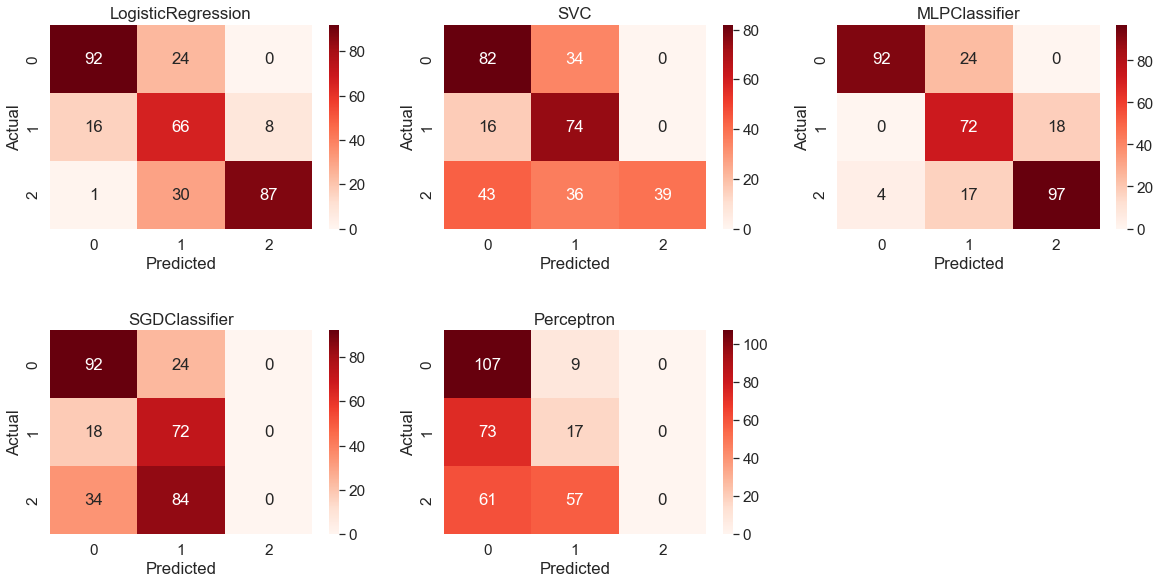

In [23]:
import seaborn as sns
# Confusion matrixes (not-normalized confusion matrix)
plt.figure(figsize=(20,15))
sns.set(font_scale=1.4)
for i in range(len(classifiers)):
    plt.subplot(3,3,i+1) #adjust this acourding to the number of algorithms
    sns.heatmap(cnfm[i], annot=True, fmt="d",cmap="Reds")
    plt.subplots_adjust(hspace = 0.5)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(clf_name[i])

In [ ]:
#Classification reports
for i in range(len(classifiers)):
    print (f"{clf_name[i]} Classification Report:" )
    print (clr[i])